##### **Jon Sedar Personal Project**

### PyMC3 Examples `pymc3_examples`

###### _2019Q4_

# GLM: Robust Regression With Outlier Detection

`glm-robust-regression-with-outlier-detection.ipynb`

Using PyMC3 for Robust Regression with Outlier Detection using the Hogg 2010 Signal vs Noise method. Crucially, this uses a custom likelihood function as a mixture of two likelihoods, one for the main data-generating function, and one for outliers.

+ This is a complementary approach to the Student-T robust regression as illustrated in Thomas Wiecki's notebook in the [PyMC3 documentation](http://pymc-devs.github.io/pymc3/GLM-robust/), and that approach is also compared here.
+ This model returns a robust estimate of linear model coefficients and an indication of which datapoints (if any) are outliers.
+ The likelihood evaluation is essentially a copy of eqn 17 in "Data analysis recipes: Fitting a model to data" - [Hogg 2010](http://arxiv.org/abs/1008.4686).
+ The model is adapted specifically from Jake Vanderplas' [implementation](http://www.astroml.org/book_figures/chapter8/fig_outlier_rejection.html) (3rd model tested, marginalizes over the probability that each point is an outlier).
+ The dataset is tiny and hardcoded into this Notebook. It contains errors in both the x and y, but we will deal here with only errors in y.


## Contents

+ [Setup](#Setup)
    + [Installation Notes](#Installation-Notes)
    + [Imports](#Imports)
    + [Local Functions](#Local-Functions)
    + [Load Data](#Load-Data)
+ [1. Basic EDA](#1.-Basic-EDA)
+ [2. Basic Feature Engineering](#2.-Basic-Feature-Engineering)
+ [3. Simple Linear Model with no Outlier Correction](#3.-Simple-Linear-Model-with-no-Outlier-Correction)
+ [4. Simple Linear Model with Robust Student-T Likelihood](#4.-Simple-Linear-Model-with-Robust-Student-T-Likelihood)

# Setup

## Installation Notes

See the project [README](https://github.com/jonsedar/pymc3_examples/blob/master/README.md) for full details. For MVP reproduction, see following notes

##### General:

+ This is a Python 3.6 project using latest available [PyMC3](https://github.com/pymc-devs/pymc3) at time of writing `pymc3=3.7`
+ Developed in 2019Q4 using [ContinuumIO Anaconda](https://www.continuum.io/downloads) distribution on a Macbook 2017 1.4GHz i7 Dual Core, 16GB RAM, OSX 10.14.6
+ If runs become unstable or Theano throws weird errors, first try clearing the cache `theano-cache clear` and rerunning the notebook.


##### Package Requirements (shown as a condaenv YAML)

```
$> less conda_env_pymc3_examples.yml

    name: pymc3_examples
    channels:
    - defaults
    dependencies:
    - python==3.6.*
    - cython
    - ipython
    - jupyter
    - mkl
    - mkl-service
    - numpy
    - scipy
    - matplotlib
    - pandas
    - scikit-learn
    - seaborn
    - patsy
    - statsmodels
    - tqdm
    - watermark
    - sphinx
    - pytest
    - nose
    - parameterized
    - pip

$> conda env create --file conda_env_pymc3_examples.yml
$> source activate pymc3_examples
$> pip install pymc3==3.7 theano arviz daft
$> jupyter notebook
```

In [1]:
%matplotlib inline
%qtconsole --style=monokai --ConsoleWidget.font_size=11

## Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# from scipy import stats, optimize
import patsy as pt
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split

import pymc3 as pm
import theano as thno
import theano.tensor as tt
import arviz as az

sns.set(style='darkgrid', palette='muted', 
        context='notebook')
plt.rcParams['figure.figsize'] = 16, 4
np.random.seed(0)

%load_ext watermark
%watermark -dtmvgp numpy,scipy,matplotlib,pandas,seaborn,pymc3,theano,arviz

2019-10-26 11:15:18 

CPython 3.6.9
IPython 7.8.0

numpy 1.17.2
scipy 1.3.1
matplotlib 3.1.1
pandas 0.25.2
seaborn 0.9.0
pymc3 3.7
theano 1.0.4
arviz 0.5.1

compiler   : GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 18.7.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit
Git hash   : 9639d24032eedb3dd679d934ac00c8ab09ab8aba


## Local Functions

In [3]:
# None

## Load Data

We'll use the Hogg 2010 data available at  https://github.com/astroML/astroML/blob/master/astroML/datasets/hogg2010test.py

It's a very small dataset so for convenience, it's hardcoded below

In [4]:
#### cut & pasted directly from the fetch_hogg2010test() function
## identical to the original dataset as hardcoded in the Hogg 2010 paper

dfhogg = pd.DataFrame(np.array([[1, 201, 592, 61, 9, -0.84],
                                 [2, 244, 401, 25, 4, 0.31],
                                 [3, 47, 583, 38, 11, 0.64],
                                 [4, 287, 402, 15, 7, -0.27],
                                 [5, 203, 495, 21, 5, -0.33],
                                 [6, 58, 173, 15, 9, 0.67],
                                 [7, 210, 479, 27, 4, -0.02],
                                 [8, 202, 504, 14, 4, -0.05],
                                 [9, 198, 510, 30, 11, -0.84],
                                 [10, 158, 416, 16, 7, -0.69],
                                 [11, 165, 393, 14, 5, 0.30],
                                 [12, 201, 442, 25, 5, -0.46],
                                 [13, 157, 317, 52, 5, -0.03],
                                 [14, 131, 311, 16, 6, 0.50],
                                 [15, 166, 400, 34, 6, 0.73],
                                 [16, 160, 337, 31, 5, -0.52],
                                 [17, 186, 423, 42, 9, 0.90],
                                 [18, 125, 334, 26, 8, 0.40],
                                 [19, 218, 533, 16, 6, -0.78],
                                 [20, 146, 344, 22, 5, -0.56]]),
                   columns=['id','x','y','sigma_y','sigma_x','rho_xy'])

## for convenience zero-base the 'id' and use as index
dfhogg['id'] = dfhogg['id'] - 1
dfhogg.set_index('id', inplace=True)

---

# 1. Basic EDA

##### Exploratory Data Analysis

Note:
+ this is very rudimentary so we can quickly get to the `pymc3`
+ the dataset contains errors in both the x and y, but we will deal here with only errors in y.
+ see the [Hogg 2010 paper](https://arxiv.org/pdf/1008.4686.pdf) for more detail

In [5]:
dfhogg.head()

,x,y,sigma_y,sigma_x,rho_xy
id,,,,,
0.0,201.0,592.0,61.0,9.0,-0.84
1.0,244.0,401.0,25.0,4.0,0.31
2.0,47.0,583.0,38.0,11.0,0.64
3.0,287.0,402.0,15.0,7.0,-0.27
4.0,203.0,495.0,21.0,5.0,-0.33


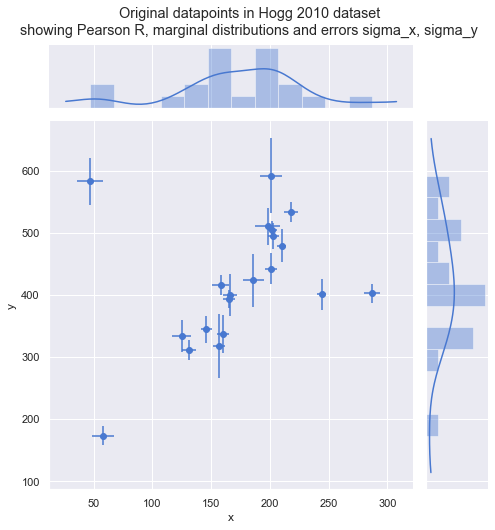

In [6]:
gd = sns.jointplot(x='x', y='y', data=dfhogg, kind='scatter', height=7,
        marginal_kws={'bins':12, 'kde':True, 'kde_kws':{'cut':1}})
_ = gd.fig.axes[0].errorbar('x', 'y', 'sigma_y', 'sigma_x', fmt='none', 
                            ecolor='#4878d0', data=dfhogg)
_ = gd.fig.suptitle(('Original datapoints in Hogg 2010 dataset' + 
        '\nshowing Pearson R, marginal distributions and errors sigma_x, sigma_y'), 
                    y=1.05)

**Observe**:  

+ Even judging just by eye, you can see these observations mostly fall on / around a straight line with positive gradient
+ It looks like a few of the datapoints may be outliers from such a line
+ Measurement error (independently on x and y) varies across the observations

---

# 2. Basic Feature Engineering

Note: ordinarily I might run through more formalised steps to split into Train and Test sets (to later help evaluate model fit), but here I'll just fit the model to the full dataset and stop at inference

## 2.1 Transform and standardize dataset

It's common practice to standardize the input values to a linear model, because this leads to coefficients sitting in the same range and beng more directly comparable. e.g. Gelman notes this in a 2007 paper: http://www.stat.columbia.edu/~gelman/research/published/standardizing7.pdf.

Note: 
+ following Gelman's paper above, I'll divide by 2 s.d. here
+ since this model is very simple, I'll just standardize directly, rather than using e.g. a scikit-learn FunctionTransformer
+ ignoring `rho_xy` for now

### Standardize (mean center and divide by 2 sd)

In [7]:
dfhoggs = (dfhogg[['x']] - dfhogg[['x']].mean(0)) / (2 * dfhogg[['x']].std(0))

Also transform the measurement error on `x`

In [8]:
dfhoggs['sigma_x'] = dfhogg['sigma_x'] / ( 2 * dfhogg['x'].std(0))

Concat the `y` and `sigma_y`

In [9]:
dfhoggs[['y', 'sigma_y']] = dfhogg[['y', 'sigma_y']].copy()

---

# 3. Simple Linear Model with no Outlier Correction

## 3.1 Specify Model

Before we get more advanced, I want to demo the fit of a simple linear model with Normal likelihood function. The priors are also Normally distributed, so this behaves like an OLS with Ridge Regression (L2 norm).

$$\bf{\hat{y}} \sim \mathcal{N}(\beta^{T} \bf{x}_{i}, \sigma)$$

where:  

+ $\beta$ = $\{1, \beta_{j \in X_{j}}\}$  <-- linear coefs in $X_{j}$, in this case `1 + x`
+ $\sigma$ = measurement error on the y axis <-- in this case we set this to the measured error `sigma_y`

Note: the dataset also has `sigma_x` and `rho_xy` available, but for this exercise, I've chosen to only use `sigma_y`

In [10]:
with pm.Model() as mdl_ols:
    
    ## Define weakly informative Normal priors to give Ridge regression
    b0 = pm.Normal('b0_intercept', mu=0, sigma=10)
    b1 = pm.Normal('b1_slope', mu=0, sigma=10)
 
    ## Define linear model
    y_est = b0 + b1 * dfhoggs['x']
    
    ## Define Normal likelihood
    likelihood = pm.Normal('likelihood', mu=y_est, sigma=dfhoggs['sigma_y'],
                           observed=dfhoggs['y'])

## 3.2 Fit Model

Note purposefully missing a step here for prior predictive checks...

### 3.2.1 Sample Posterior

In [11]:
with mdl_ols:
    trc_ols = pm.sample(tune=5000, draws=500, chains=3, cores=3, 
                    init='advi+adapt_diag', n_init=50000, progressbar=True)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 4,003.5:  20%|██        | 10181/50000 [00:07<00:29, 1350.05it/s]
Convergence achieved at 10300
Interrupted at 10,299 [20%]: Average Loss = 4,033.7
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [b1_slope, b0_intercept]
Sampling 3 chains: 100%|██████████| 16500/16500 [00:08<00:00, 1866.95draws/s]


### 3.2.2 View Diagnostics

NOTE: We will illustrate this OLS fit and compare to the datapoints in the final comparison plot

##### Traceplot

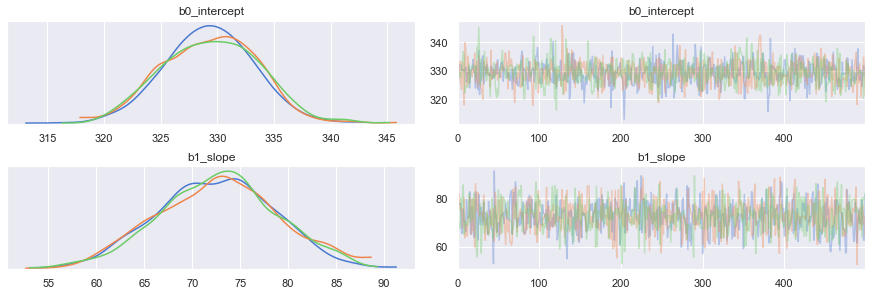

In [12]:
_ = az.plot_trace(trc_ols, combined=False, compact=False)

##### View posterior joint distribution (since the model has only 2 coeffs, we can easily view this as a 2D joint distribution)

In [35]:
df_trc_ols = pm.trace_to_dataframe(trc_ols)

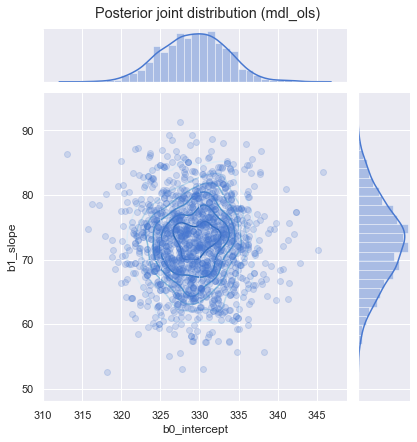

In [14]:
gd = sns.jointplot(x='b0_intercept', y='b1_slope', data=df_trc_ols, height=6, 
                   marginal_kws={'kde':True, 'kde_kws':{'cut':1}},
                   joint_kws={'alpha':0.2})
gd.plot_joint(sns.kdeplot, zorder=0, cmap="Blues", n_levels=7)
_ = gd.fig.suptitle('Posterior joint distribution (mdl_ols)', y=1.02)

---

# 4. Simple Linear Model with Robust Student-T Likelihood

I've added this brief section in order to directly compare the Student-T based method exampled in Thomas Wiecki's notebook in the [PyMC3 documentation](http://pymc-devs.github.io/pymc3/GLM-robust/)

Instead of using a Normal distribution for the likelihood, we use a Student-T, which has fatter tails. In theory this allows outliers to have a smaller influence in the likelihood estimation. This method does not produce inlier / outlier flags but is simpler and faster to run than the Signal Vs Noise model below, so a comparison seems worthwhile.

**Note:** I'll constrain the Student-T 'degrees of freedom' parameter `nu` to be an integer, but otherwise leave it as just another stochastic to be inferred: no need for prior knowledge.

## 4.1 Specify Model

In this modification, we allow the likelihood to be more robust to outliers (have fatter tails)

$$\bf{\hat{y}} \sim \mathcal{StudentT}(\beta^{T} \bf{x}_{i}, \sigma, \nu)$$

where:  

+ $\beta$ = $\{1, \beta_{j \in X_{j}}\}$  <-- linear coefs in $X_{j}$, in this case `1 + x`
+ $\sigma$ = measurement error on the y axis <-- in this case we set this to the measured error `sigma_y`
+ $\nu$ = degress of freedom, allowing a pdf with fat tails and thus less influence from outlier datapoints

Note: the dataset also has `sigma_x` and `rho_xy` available, but for this exercise, I've chosen to only use `sigma_y`

In [15]:
with pm.Model() as mdl_studentt:
    
    ## Define weakly informative Normal priors to give Ridge regression
    b0 = pm.Normal('b0_intercept', mu=0, sd=10)
    b1 = pm.Normal('b1_slope', mu=0, sd=10)
 
    ## Define linear model
    y_est = b0 + b1 * dfhoggs['x']
       
    ## define prior for StudentT degrees of freedom
    ## InverseGamma has nice properties: continuous (can use HMC) 
    ## and support x∈(0,∞)
    nu = pm.InverseGamma('nu', alpha=1, beta=1)

    ## Define Student T likelihood
    likelihood = pm.StudentT('likelihood', mu=y_est, 
                             sigma=dfhoggs['sigma_y'], nu=nu, 
                             observed=dfhoggs['y'])


## 4.2 Fit Model

### 4.2.1 Sample Posterior

In [16]:
with mdl_studentt:
    trc_studentt = pm.sample(tune=5000, draws=500, chains=3, cores=3, 
                    init='advi+adapt_diag', n_init=50000, progressbar=True)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 186.3:  19%|█▉        | 9661/50000 [00:08<00:36, 1112.89it/s] 
Convergence achieved at 9700
Interrupted at 9,699 [19%]: Average Loss = 188.64
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [nu, b1_slope, b0_intercept]
Sampling 3 chains: 100%|██████████| 16500/16500 [00:11<00:00, 1381.06draws/s]


### 4.2.2 View Diagnostics

NOTE: We will illustrate this StudentT fit and compare to the datapoints in the final comparison plot

##### Traceplot

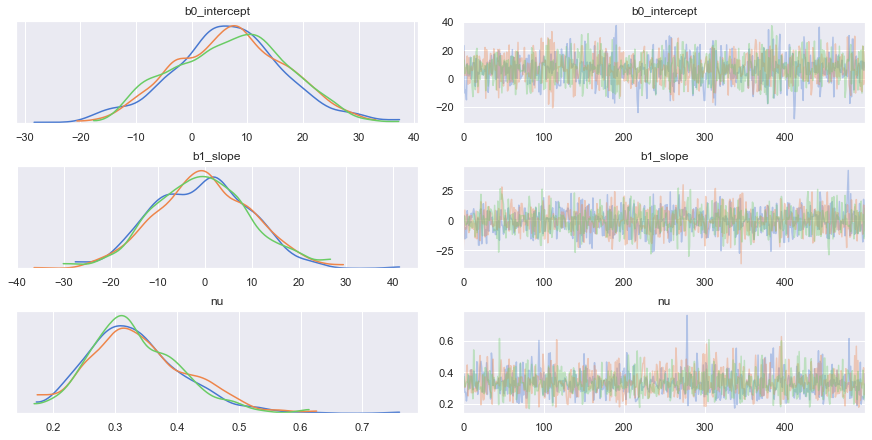

In [17]:
_ = az.plot_trace(trc_studentt, combined=False, compact=False)

##### View posterior joint distribution (since the model has only 2 coeffs, we can easily view this as a 2D joint distribution)

In [34]:
df_trc_studentt = pm.trace_to_dataframe(trc_studentt)

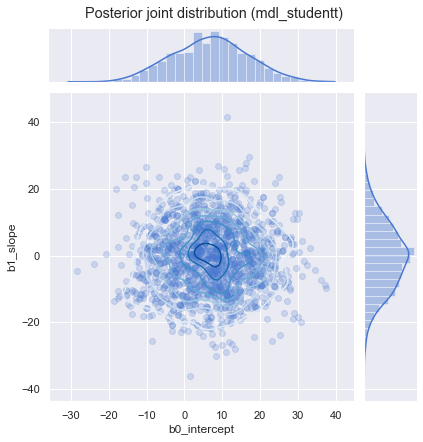

In [86]:
gd = sns.jointplot(x='b0_intercept', y='b1_slope', data=df_trc_studentt, 
            height=6, marginal_kws={'kde':True, 'kde_kws':{'cut':1}},
            joint_kws={'alpha':0.2})
gd.plot_joint(sns.kdeplot, zorder=2, cmap='Blues', n_levels=7)
_ = gd.fig.suptitle('Posterior joint distribution (mdl_studentt)', y=1.02)

In [159]:
fts = ['b0_intercept', 'b1_slope']
df_trc = pd.concat((df_trc_ols[fts], df_trc_studentt[fts]), axis=0, sort=False)
df_trc['model'] = np.repeat(['ols', 'studentt'], len(df_trc_ols))

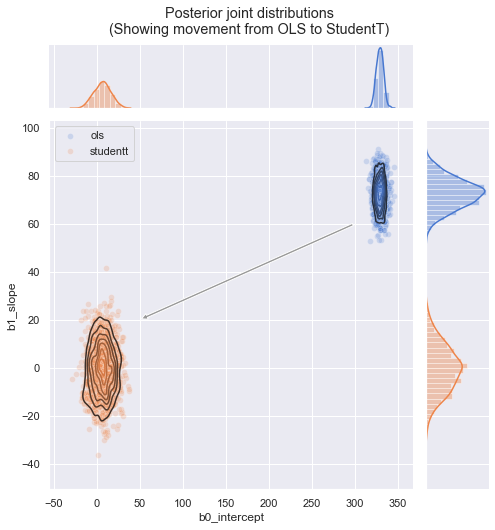

In [157]:
gd = sns.JointGrid(x='b0_intercept', y='b1_slope', data=df_trc, height=7)
_ = gd.fig.suptitle(('Posterior joint distributions' + 
                     '\n(Showing movement from OLS to StudentT)'), y=1.05)

_, x_bin_edges = np.histogram(df_trc['b0_intercept'], 60)
_, y_bin_edges = np.histogram(df_trc['b1_slope'], 60)

for idx, grp in df_trc.groupby('model'):
    _ = sns.scatterplot(grp['b0_intercept'], grp['b1_slope'], 
                        ax=gd.ax_joint, alpha=0.2, label=idx)
    _ = sns.kdeplot(grp['b0_intercept'], grp['b1_slope'], 
                        ax=gd.ax_joint, zorder=2, n_levels=7)
    _ = sns.distplot(grp['b0_intercept'], ax=gd.ax_marg_x, kde_kws={'cut':1}, 
                         bins=x_bin_edges, axlabel=False)
    _ = sns.distplot(grp['b1_slope'], ax=gd.ax_marg_y, kde_kws={'cut':1}, 
                         bins=y_bin_edges, vertical=True, axlabel=False)
    
_ = gd.ax_joint.annotate('', xy=(50,20), xytext=(300,60), 
        arrowprops={'arrowstyle':'simple', 'facecolor':'#999999'})
_ = gd.ax_joint.legend()

**Observe:**

+ Both parameters `b0_intercept` and `b1_slope` are far, far closer to 0 than they were in the OLS regression
+ The fitted degree of freedom parameter `nu < 1`, indicating that a fat-tailed Student-T likelihood has a better fit than a thin-tailed one (Normal-like) 
+ These indicate far less influence from outlier values

**NOTE:** We'll illustrate this Student-T fit and compare to the datapoints in the final plot

---

# 5. Create Robust Model with Outliers: Hogg Method

Please read the paper (Hogg 2010) and Jake Vanderplas' code for more complete information about the modelling technique.

The general idea is to create a 'mixture' model whereby datapoints can be described by either:

1. the proposed (linear) model (thus a datapoint is an inlier), or
2. a second model, which for convenience we also propose to be linear, but allow it to have a different mean and variance (thus a datapoint is an outlier)


## 5.1 Specify Model

The likelihood is evaluated over a mixture of two likelihoods, one for 'inliers', one for 'outliers'. A Bernouilli distribution is used to randomly assign datapoints in N to either the inlier or outlier groups, and we sample the model as usual to infer robust model parameters and inlier / outlier flags:

$$
\mathcal{logL} = \sum_{i}^{i=N} log \left[ \frac{(1 - B_{i})}{\sqrt{2 \pi \sigma_{in}^{2}}} exp \left( - \frac{(x_{i} - \mu_{in})^{2}}{2\sigma_{in}^{2}} \right) \right] + \sum_{i}^{i=N} log \left[ \frac{B_{i}}{\sqrt{2 \pi (\sigma_{in}^{2} + \sigma_{out}^{2})}} exp \left( - \frac{(x_{i}- \mu_{out})^{2}}{2(\sigma_{in}^{2} + \sigma_{out}^{2})} \right) \right]
$$

where:  
+ $B_{i}$ is Bernoulli-distibuted $B_{i} \in \{0_{(inlier)},1_{(outlier)}\}$



##### Implementation note:
    
A version of this Notebook was submitted and accepted into the [pymc3 docs](https://docs.pymc.io/notebooks/GLM-robust-with-outlier-detection.html) on 2015-12-21 with a log-likelihood specified directly in `theano`. In the time since, the `pm.DensityDist` class has been updated to require a custom `random` function to enable sampling, and on 2018-07-24, Thomas Wiecki kindly reimplemented this model specification accordingly, using the `Normal` and `Potential` classes from `pymc3`. 

This use of the `Potential` class combined with the to create a likelihood is a new idea to me. It makes hand-wavy sense in [the docs](http://pymc-devs.github.io/pymc/modelbuilding.html#the-potential-class), and it seems to make it easier to build models where a feature is not observed e.g. the Bernoulli switching variable here.

I found a few more resources on this usage of `Potential` that are worth referring to:

+ [Junpenglao's presentation on likelihoods](https://github.com/junpenglao/All-that-likelihood-with-PyMC3) at PyData Berlin July 2018
+ worked examples on [Discourse](https://discourse.pymc.io/t/pm-potential-much-needed-explanation-for-newbie/2341) and [Cross Validated](https://stats.stackexchange.com/a/252607/10625). 
+ and the pymc3 port of CamDP's Probabilistic Programming and Bayesian Methods for Hackers, Chapter 5 Loss Functions, [Example: Optimizing for the Showcase on The Price is Right](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter5_LossFunctions/Ch5_LossFunctions_PyMC3.ipynb)

In [167]:
with pm.Model() as mdl_signoise:
    
    # get into the practice of stating input data as Theano shared vars
    tsv_x = pm.Data('tsv_x', dfhoggs['x'])            # .values.ravel()
    tsv_y = pm.Data('tsv_y', dfhoggs['y'])
    tsv_sigma_y = pm.Data('tsv_sigma_y', dfhoggs['sigma_y'])
    
    
    # weakly informative Normal priors (L2 ridge reg) for inliers
    b0 = pm.Normal('b0_intercept', mu=0, sigma=10, testval=pm.floatX(0.1))
    b1 = pm.Normal('b1_slope', mu=0, sigma=1, testval=pm.floatX(1.))
 
    # linear model for mean for inliers
    y_est_in = b0 + b1 * tsv_x

    # proposed and unknown mean for outliers
    y_est_out = pm.Normal('y_est_out', mu=0, sigma=10, testval=pm.floatX(1.))
    
    # weakly informative prior for additional variance for outliers
    sigma_y_out = pm.HalfNormal('sigma_y_out', sigma=10, testval=pm.floatX(1.))
   
    # create in/outlier distributions to get a logp evidenced on the observed y
    # note these are not likelihoods
    inlier_logp = pm.Normal.dist(mu=y_est_in, 
                                 sigma=tsv_sigma_y
                                ).logp(tsv_y)

    outlier_logp = pm.Normal.dist(mu=y_est_out, 
                                  sigma=tsv_sigma_y + sigma_y_out
                                 ).logp(tsv_y)
    
    # Bernoulli in/outlier classification constrained to [0, .5] for symmetry
    frac_outliers = pm.Uniform('frac_outliers', lower=0.0, upper=.5)
    is_outlier = pm.Bernoulli('is_outlier', p=frac_outliers, 
                              shape=tsv_x.eval().shape[0], 
                              testval=np.random.rand(tsv_x.eval().shape[0]) < 0.2)

    # Custom likelihood restated as an (unobserved) Potential
    potential = pm.Potential('obs', ((1-is_outlier) * inlier_logp).sum() + 
                             (is_outlier * outlier_logp).sum())
    

## 5.2 Fit Model

### 5.2.1 Sample Posterior

Note that `pm.sample` conveniently and automatically creates the compound sampling process to first estimate the Bernoulli flag `is_outlier`, then secondly sample the continuous variables

In [168]:
with mdl_signoise:
    trc_signoise = pm.sample(tune=5000, draws=500, chains=3, cores=3, 
                    init='advi+adapt_diag', n_init=50000, progressbar=True)

Multiprocess sampling (3 chains in 3 jobs)
CompoundStep
>NUTS: [frac_outliers, sigma_y_out, y_est_out, b1_slope, b0_intercept]
>BinaryGibbsMetropolis: [is_outlier]
Sampling 3 chains: 100%|██████████| 16500/16500 [00:39<00:00, 419.74draws/s]


### 5.2.2 View Diagnostics

NOTE: We will illustrate this model fit and compare to the datapoints in the final comparison plot

##### Traceplot

/Users/jon/anaconda/envs/pymc3_examples/lib/python3.6/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


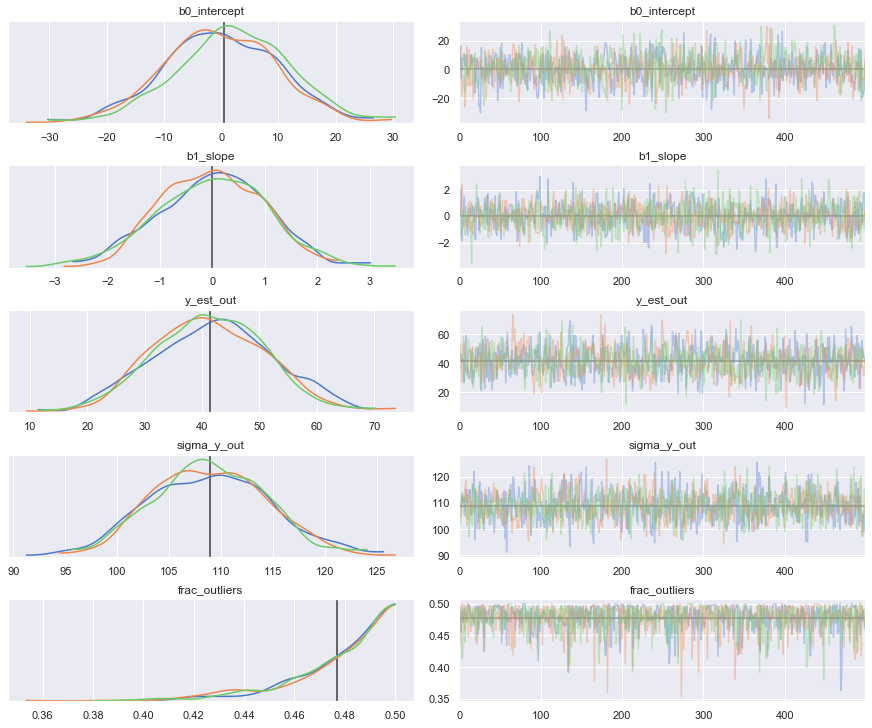

In [172]:
rvs = ['b0_intercept', 'b1_slope', 'y_est_out', 'sigma_y_out', 'frac_outliers']
_ = az.plot_trace(trc_signoise, var_names=rvs,
                 lines=tuple([(k, {}, v['mean'])
                              for k, v in pm.summary(trc_signoise, varnames=rvs).iterrows()]),
                 combined=False, compact=False)

**NOTE:**

+ During development I've found that 3 datapoints id=[1,2,3] are always indicated as outliers, but the remaining ordering of datapoints by decreasing outlier-hood is unstable between runs: the posterior surface appears to have a small number of solutions with very similar probability.
+ The NUTS sampler seems to work okay, and indeed it's a nice opportunity to demonstrate a custom likelihood which is possible to express as a theano function (thus allowing a gradient-based sampler like NUTS). However, with a more complicated dataset, I would spend time understanding this instability and potentially prefer using more samples under Metropolis-Hastings.

In [174]:
raise ValueError('Stop here WIP')

ValueError: Stop here WIP

---

---

# Declare Outliers and Compare Plots

##### View ranges for inliers / outlier predictions

At each step of the traces, each datapoint may be either an inlier or outlier. We hope that the datapoints spend an unequal time being one state or the other, so let's take a look at the simple count of states for each of the 20 datapoints.

In [ ]:
outlier_melt = pd.melt(pd.DataFrame(traces_signoise['is_outlier', -1000:],
                                   columns=['[{}]'.format(int(d)) for d in dfhoggs.index]),
                      var_name='datapoint_id', value_name='is_outlier')
ax0 = sns.pointplot(y='datapoint_id', x='is_outlier', data=outlier_melt,
                   kind='point', join=False, ci=None, size=4, aspect=2)

_ = ax0.vlines([0,1], 0, 19, ['b','r'], '--')

_ = ax0.set_xlim((-0.1,1.1))
_ = ax0.set_xticks(np.arange(0, 1.1, 0.1))
_ = ax0.set_xticklabels(['{:.0%}'.format(t) for t in np.arange(0,1.1,0.1)])

_ = ax0.yaxis.grid(True, linestyle='-', which='major', color='w', alpha=0.4)
_ = ax0.set_title('Prop. of the trace where datapoint is an outlier')
_ = ax0.set_xlabel('Prop. of the trace where is_outlier == 1')

**Observe**:

+ The plot above shows the number of samples in the traces in which each datapoint is marked as an outlier, expressed as a percentage.
+ In particular, 3 points [1, 2, 3] spend >=95% of their time as outliers
+ Contrastingly, points at the other end of the plot close to 0% are our strongest inliers.
+ For comparison, the mean posterior value of `frac_outliers` is ~0.35, corresponding to roughly 7 of the 20 datapoints. You can see these 7 datapoints in the plot above, all those with a value >50% or thereabouts.
+ However, only 3 of these points are outliers >=95% of the time. 
+ See note above regarding instability between runs.

The 95% cutoff we choose is subjective and arbitrary, but I prefer it for now, so let's declare these 3 to be outliers and see how it looks compared to Jake Vanderplas' outliers, which were declared in a slightly different way as points with means above 0.68.

##### Declare outliers

**Note:**
+ I will declare outliers to be datapoints that have value == 1 at the 5-percentile cutoff, i.e. in the percentiles from 5 up to 100, their values are 1. 
+ Try for yourself altering cutoff to larger values, which leads to an objective ranking of outlier-hood.

In [ ]:
cutoff = 5
dfhoggs['outlier'] = np.percentile(traces_signoise[-1000:]['is_outlier'],cutoff, axis=0)
dfhoggs['outlier'].value_counts()

## Posterior Prediction Plots for OLS vs StudentT vs SignalNoise

In [ ]:
g = sns.FacetGrid(dfhoggs, size=8, hue='outlier', hue_order=[True,False],
                  palette='Set1', legend_out=False)

lm = lambda x, samp: samp['b0_intercept'] + samp['b1_slope'] * x

pm.glm.plot_posterior_predictive(traces_ols[-1000:],
        eval=np.linspace(-3, 3, 10), lm=lm, samples=200, color='#22CC00', alpha=.2)

pm.glm.plot_posterior_predictive(traces_studentt[-1000:], lm=lm,
        eval=np.linspace(-3, 3, 10), samples=200, color='#FFA500', alpha=.5)

pm.glm.plot_posterior_predictive(traces_signoise[-1000:], lm=lm,
        eval=np.linspace(-3, 3, 10), samples=200, color='#357EC7', alpha=.3)

_ = g.map(plt.errorbar, 'x', 'y', 'sigma_y', 'sigma_x', marker="o", ls='').add_legend()

_ = g.axes[0][0].annotate('OLS Fit: Green\nStudent-T Fit: Orange\nSignal Vs Noise Fit: Blue',
                          size='x-large', xy=(1,0), xycoords='axes fraction',
                          xytext=(-160,10), textcoords='offset points')
_ = g.axes[0][0].set_ylim(ylims)
_ = g.axes[0][0].set_xlim(xlims)

**Observe**:

+ The posterior preditive fit for:
    + the **OLS model** is shown in **Green** and as expected, it doesn't appear to fit the majority of our datapoints very well, skewed by outliers
    + the **Robust Student-T model** is shown in **Orange** and does appear to fit the 'main axis' of datapoints quite well, ignoring outliers
    + the **Robust Signal vs Noise model** is shown in **Blue** and also appears to fit the 'main axis' of datapoints rather well, ignoring outliers.
    
    
+ We see that the **Robust Signal vs Noise model** also yields specific estimates of _which_ datapoints are outliers:
    + 17 'inlier' datapoints, in **Blue** and
    + 3 'outlier' datapoints shown in **Red**.
    + From a simple visual inspection, the classification seems fair, and agrees with Jake Vanderplas' findings.
    
    
+ Overall, it seems that:
    + the **Signal vs Noise model** behaves as promised, yielding a robust regression estimate and explicit labelling of inliers / outliers, but
    + the **Signal vs Noise model** is quite complex and whilst the regression seems robust and stable, the actual inlier / outlier labelling seems slightly unstable
    + if you simply want a robust regression without inlier / outlier labelling, the **Student-T model** may be a good compromise, offering a simple model, quick sampling, and a very similar estimate.

---

---

# Notes

In [ ]:
# def logp_signoise(y_obs, is_outlier, y_est_in, sigma_y_in, y_est_out, sigma_y_out):
#     """ Define custom loglikelihood for inliers vs outliers. 
#         NOTE: in this particular case we don't need to use theano's @as_op 
#         decorator because (as stated by Twiecki in conversation) that's only 
#         required if the likelihood cannot be expressed as a theano expression.
#         We also now get the gradient computation for free.
#     """   
    
#     # likelihood for inliers
#     pdfs_in = tt.exp(-(y_obs - y_est_in + 1e-4)**2 / (2 * sigma_y_in**2)) 
#     pdfs_in /= tt.sqrt(2 * np.pi * sigma_y_in**2)
#     logL_in = tt.sum(T.log(pdfs_in) * (1 - is_outlier))

#     # likelihood for outliers
#     pdfs_out = tt.exp(-(y_obs - y_est_out + 1e-4)**2 / (2 * (sigma_y_in**2 + sigma_y_out**2))) 
#     pdfs_out /= tt.sqrt(2 * np.pi * (sigma_y_in**2 + sigma_y_out**2))
#     logL_out = tt.sum(tt.log(pdfs_out) * is_outlier)

#     return logL_in + logL_out



In [ ]:
# with pm.Model() as mdl_signoise:
    
#     ## Define weakly informative Normal priors to give Ridge regression
#     b0 = pm.Normal('b0_intercept', mu=0, sigma=10)
#     b1 = pm.Normal('b1_slope', mu=0, sigma=10)
 
#     ## Define linear model
#     y_est_in = b0 + b1 * dfhoggs['x']

#     ## Define weakly informative priors for the mean and variance of outliers
#     y_est_out = pm.Normal('y_est_out', mu=0, sd=100)
# #     sigma_y_out = pm.HalfNormal('sigma_y_out', sd=100)

#     ## Define Bernoulli inlier / outlier flags according to a hyperprior 
#     ## fraction of outliers, itself constrained to [0,.5] for symmetry
#     frac_outliers = pm.Uniform('frac_outliers', lower=0., upper=.5)
#     is_outlier = pm.Bernoulli('is_outlier', p=frac_outliers, shape=dfhoggs.shape[0])  
               
#     ## Use custom likelihood using DensityDist
#     likelihood = pm.DensityDist('likelihood', logp_signoise, 
#                     observed={
#                         'y_obs': dfhoggs['y'], 
#                         'y_est_in': y_est_in, 'sigma_y_in': dfhoggs['sigma_y'],
#                         'is_outlier': is_outlier,
#                         'y_est_out': y_est_out, 'sigma_y_out': dfhoggs['sigma_y']})



Version history (by contribution to pymc3 examples docs):

version | date | author | changes
:--- | :--- | :--- | :---
1.0 | 2015-12-21 | [jonsedar](https://github.com/jonsedar) | Create and publish
2.0 | 2018-07-24 | [twiecki](https://github.com/twiecki) | Restate outlier model using `pm.Normal.dist().logp()` and `pm.Potential()`
2.1 | 2019-11-01 | [jonsedar](https://github.com/jonsedar) | Restate nu in StudentT model to be more efficient, drop explicit use of theano shared vars, generally improve text / layout / formatting